In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
from island_ga import IslandGGA 
from chromosome import Chromosome 
import itertools

In [2]:
#rename column to remove spaces in column names
data=pd.read_csv('HistoricalQuotes.csv')
aapl =data.rename(columns={' Close/Last': 'close', ' Volume': 'volume',
                           ' Open':'open',' High':'high',' Low':'low'})
                        

#change date string into date format and sort the dataframe in ascending order
aapl[['Date']] = aapl[['Date']].applymap(lambda x: datetime.strptime(x,'%m/%d/%Y').date())
aapl =aapl.sort_values(by='Date')
#change dataframe dtypes to float
cols = [i for i in aapl if i not in ['Date','volume']]
def to_float(x):
    x = x.strip()
    return float(x[1:])

aapl[cols]=aapl[cols].applymap(to_float)

#Create Signals using Talib library
aapl['5EMA'] = ta.SMA(np.array(aapl['close']),5)
aapl['20EMA'] = ta.EMA(np.array(aapl['close']), timeperiod = 20)
aapl['RSI'] = ta.RSI(np.array(aapl['close']), timeperiod = 14)
aapl['WILLR'] = ta.WILLR(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['MOM'] = ta.MOM(np.array(aapl['close']), timeperiod=5)
aapl['CCI'] = ta.CCI(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)
aapl['SLOWK'],aapl['SLOWD'] = ta.STOCH(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), fastk_period=14, slowk_period=3, slowd_period=3)
aapl['MACD'],aapl['MACDSIGNAL'],aapl['MACDHIST'] = ta.MACD(np.array(aapl['close']), fastperiod=12, slowperiod=26, signalperiod=9)
aapl['DMI'] = ta.DX(np.array(aapl['high']), np.array(aapl['low']), np.array(aapl['close']), timeperiod=14)   

In [3]:
#  """Based on parameter setting adopted in Chen et al (2021) """
def generate_candidate_trading_signals(data):
    """Based on parameter setting adopted in Chen et al (2021) """
    conditions ={'TS1':[
                (data['5EMA'] > data['20EMA']),
                (data['5EMA'] < data['20EMA'])],
                 'TS2':[
                (data['RSI'] > 30),
                (data['RSI'] < 70),
                ],
                 'TS3':[
                (data['WILLR'] < 80),
                (data['WILLR'] > 20),
                ],
                 'TS4':[
                (data['MOM'] > 0 ),
                (data['MOM'] <= 0),
                ],
                 'TS5': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= 100),
                ],
                 'TS6': [
                (data['SLOWK'] > data['SLOWD']) & (data['SLOWD'] < 20),
                (data['SLOWK'] < data['SLOWD']) & (data['SLOWD'] > 80)],
                'TS7': [
                (data['MACD'] > 0 ),
                (data['MACD'] <= 0)],
                'TS8': [
                (data['CCI'] > 100 ),
                (data['CCI'] <= -100)]}

    # create a list of the values we want to assign for each condition 1: buy, 0: sell
    values = [1, 0]

    # create a new column and use np.select to assign values to it using our lists as arguments
    for i in conditions:
        data[i] = np.select(conditions[i], values)
    strategies =list(conditions.keys())
    return data,strategies
#split data
train = aapl[(aapl['Date'] <= date(2019,12,31))]
test = aapl[(aapl['Date'] > date(2019,12,31))]
train_data, strategies =generate_candidate_trading_signals(train.copy())
test_data, test_strategies =generate_candidate_trading_signals(test.copy())

Running master_slave
Generation 0: Best fitness = 352.013472497103 Average fitness = 200.59550183394208
Generation 1: Best fitness = 352.013472497103 Average fitness = 223.1657100497791
Generation 2: Best fitness = 352.013472497103 Average fitness = 244.16627903078333
Generation 3: Best fitness = 352.013472497103 Average fitness = 258.45010148376275
Generation 4: Best fitness = 352.013472497103 Average fitness = 267.6100601956202
Generation 5: Best fitness = 352.013472497103 Average fitness = 277.04591027127765
Generation 6: Best fitness = 352.013472497103 Average fitness = 286.2842464528541
Generation 7: Best fitness = 352.013472497103 Average fitness = 295.3392310673267
Generation 8: Best fitness = 352.013472497103 Average fitness = 302.65789492646456
Generation 9: Best fitness = 352.013472497103 Average fitness = 309.0417581972986
Generation 10: Best fitness = 352.0134724971031 Average fitness = 313.59163070948887
Generation 11: Best fitness = 352.0134724971031 Average fitness = 316

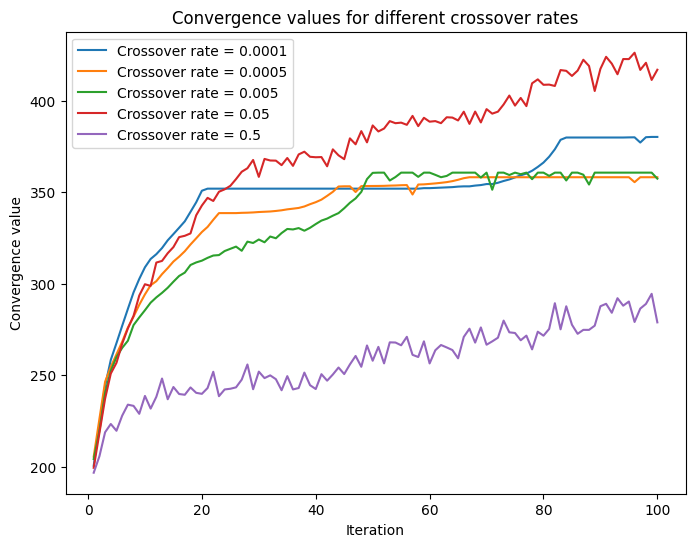

In [4]:
# master_slave
values = []
crossover_rates =[0.0001, 0.0005, 0.005, 0.05, 0.5]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=80,num_iter=100,n_migrants=100,pSize=200,r_cross=i,r_mut=0.0001,strategies=strategies,evolve_strategy="master_slave")
    ga.evolve()
    #v =  [i[2] for i in ga.convergence_values]
    values.append(ga.convergence_values)
# convergence values for each crossover rate
convergence_values = values
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 101), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

Running ring
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Generation 0: Best fitness = 388.8221316390992 Average Fitness( last island) = 195.9120560729307
Generation 1: Best fitness = 388.8221316390992 Average Fitness( last island) = 213.02451727193346
Generation 2: Best fitness = 388.8221316390992 Average Fitness( last island) = 232.97059949177253
Generation 3: Best fitness = 388.8221316390992 Average Fitness( last island) = 247.7051332191993
Generation 4: Best fitness = 388.8221316390992 Average Fitness( last island) = 254.9151983064609
Generation 5: Best fitness = 388.8221316390992 Average Fitness( last island) = 261.0883398731062
Generation 6: Best fitness = 388.8221316390992 Average Fitness( last island) = 267.3427905582742
Generation 7: Best fitness = 388.8221316390992 Average Fitness( last island) = 272.81822158073146
Generation 8: Best fitness = 388.8221316390992 Average Fit

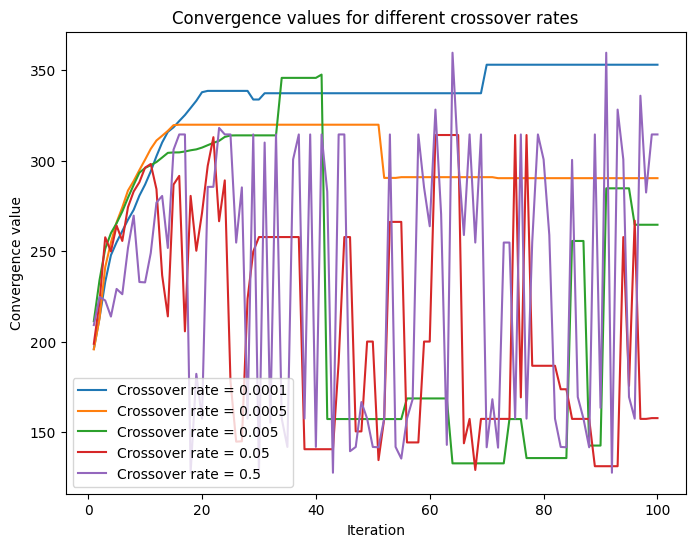

In [6]:
# ring
values = []
crossover_rates = [0.0001, 0.0005, 0.005, 0.05, 0.5]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=100,num_iter=100,n_migrants=100,pSize=200,r_cross=i,r_mut=0.0001,strategies=strategies,evolve_strategy="ring")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(v)
# convergence values for each crossover rate
convergence_values = values
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 101), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

Running nearest
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Generation 0: Best fitness = 323.07228022568603 Average Fitness( last island) = 217.02976727516815
Generation 1: Best fitness = 323.07228022568603 Average Fitness( last island) = 241.18055428318502
Generation 2: Best fitness = 323.07228022568603 Average Fitness( last island) = 260.02865511443235
Generation 3: Best fitness = 323.07228022568603 Average Fitness( last island) = 273.48708763382206
Generation 4: Best fitness = 323.07228022568603 Average Fitness( last island) = 282.80328077779984
Generation 5: Best fitness = 323.0722802256861 Average Fitness( last island) = 291.1666394172303
Generation 6: Best fitness = 323.0722802256861 Average Fitness( last island) = 296.5763228087984
Generation 7: Best fitness = 323.0722802256861 Average Fitness( last island) = 302.4514941117845
Generation 8: Best fitness = 323.07228022568603 

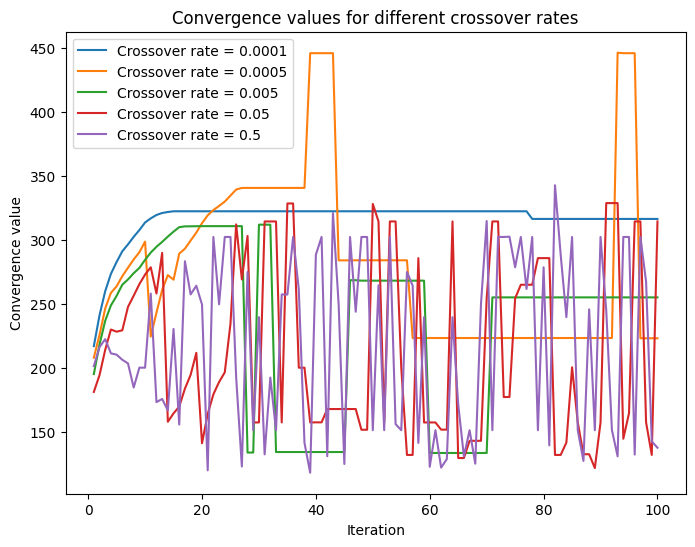

In [7]:
# nearest
values = []
crossover_rates = [0.0001, 0.0005, 0.005, 0.05, 0.5]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=100,num_iter=100,n_migrants=100,pSize=200,r_cross=i,r_mut=0.0001,strategies=strategies,evolve_strategy="nearest")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(v)
import matplotlib.pyplot as plt
import numpy as np

# convergence values for each crossover rate

convergence_values = values
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 101), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

In [9]:
# multikuti
values = []
crossover_rates = [0.0001, 0.0005, 0.005, 0.05, 0.5]

for i in crossover_rates:
    ga = IslandGGA(data=train_data,num_islands=3,m_iter=100,num_iter=100,n_migrants=100,pSize=200,r_cross=i,r_mut=0.0001,strategies=strategies,evolve_strategy="multikuti")
    ga.evolve()
    v =  [i[2] for i in ga.convergence_values]
    values.append(v)


# convergence values for each crossover rate
convergence_values = values
# plot the convergence values for each crossover rate
plt.figure(figsize=(8, 6))
for i in range(len(crossover_rates)):
    plt.plot(np.arange(1, 101), convergence_values[i], label='Crossover rate = ' + str(crossover_rates[i]))
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for different crossover rates')
plt.legend()
plt.show()

Running multikuti
Island 0 Migration -Left island 2 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right island 0
Generation 0: Best fitness = 346.988543961148 Average Fitness( last island) = 202.4441802923002
Generation 1: Best fitness = 346.988543961148 Average Fitness( last island) = 222.85964671559003
Generation 2: Best fitness = 346.988543961148 Average Fitness( last island) = 243.7660317531737
Generation 3: Best fitness = 346.988543961148 Average Fitness( last island) = 254.71349221418865
Generation 4: Best fitness = 346.988543961148 Average Fitness( last island) = 262.886030938713
Generation 5: Best fitness = 346.988543961148 Average Fitness( last island) = 271.0093561174264
Generation 6: Best fitness = 346.988543961148 Average Fitness( last island) = 277.49573970335797
Generation 7: Best fitness = 346.988543961148 Average Fitness( last island) = 282.85832955230126
Generation 8: Best fitness = 346.988543961148 Average Fitness

KeyboardInterrupt: 